In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
import statsmodels.formula.api as smf

data = pd.read_csv('/workspace/results/ndvi.csv')

/tmp/ipykernel_11738/2816956475.py:9: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/workspace/results/ndvi.csv')


In [2]:
# Data manipulation

# Rename columns
data = data.rename(columns={
    'gradient_mean': 'grad_mean',
    'gradient_median': 'grad_med',
    'gradient_stddev': 'grad_std',
    'hm_stddev': 'hm_std',
    'hm_median': 'hm_med'
})

# Pivot to collapse zones - this ensures one row per WDPA_PID per year
zones_data = data.pivot_table(
    index=['WDPA_PID', 'year'], 
    columns='zone',
    values=['grad_mean', 'grad_med', 'hm_mean', 'hm_med'],
    aggfunc='first'  # Use first value if duplicates exist
).reset_index()

zones_data.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in zones_data.columns]

# Edge level calculations
zones_data['edge_level'] = zones_data['grad_mean_-1_1km'] / ((zones_data['grad_mean_-1_-3km'] + zones_data['grad_mean_1_3km']) / 2)
zones_data['edge_level_far'] = zones_data['grad_mean_-1_1km'] / ((zones_data['grad_mean_-3_-5km'] + zones_data['grad_mean_3_5km']) / 2)
zones_data['edge_level_med'] = zones_data['grad_med_-1_1km'] / ((zones_data['grad_med_-1_-3km'] + zones_data['grad_med_1_3km']) / 2)
zones_data['edge_level_med_far'] = zones_data['grad_med_-1_1km'] / ((zones_data['grad_med_-3_-5km'] + zones_data['grad_med_3_5km']) / 2)

# Calculate mean across all zones
hm_mean_cols = [col for col in zones_data.columns if col.startswith('hm_mean_')]
hm_med_cols = [col for col in zones_data.columns if col.startswith('hm_med_')]
zones_data['hm_mean_all'] = zones_data[hm_mean_cols].mean(axis=1)
zones_data['hm_med_all'] = zones_data[hm_med_cols].mean(axis=1)

# Drop zone-specific columns (but keep hm_mean_all and hm_med_all)
cols_to_drop = [col for col in zones_data.columns if any(
    col.startswith(prefix) for prefix in ['grad_mean_', 'grad_med_', 'grad_std_', 'hm_mean_', 'hm_med_', 'hm_std_']
) and not col.endswith('_all')]
zones_data = zones_data.drop(columns=cols_to_drop)

# Merge with other data - get one row per WDPA_PID per year
other_cols = [col for col in data.columns if col not in ['zone', 'grad_mean', 'grad_med', 'grad_std', 'hm_mean', 'hm_med', 'hm_std']]
df_other = data[other_cols].drop_duplicates(subset=['WDPA_PID', 'year'])

df = zones_data.merge(df_other, on=['WDPA_PID', 'year'], how='left')

# Add country data
country = pd.read_csv("https://pkgstore.datahub.io/JohnSnowLabs/country-and-continent-codes-list/country-and-continent-codes-list-csv_csv/data/b7876b7f496677669644f3d1069d3121/country-and-continent-codes-list-csv_csv.csv")
country = country.rename(columns={'Three_Letter_Country_Code': 'ISO3'})
df = df.merge(country, on='ISO3', how='left')

# Verify data structure
n_pas = df['WDPA_PID'].nunique()
n_years = df['year'].nunique()
expected_rows = n_pas * n_years

print(f"Loaded data: {len(df)} rows, {n_pas} unique protected areas, {n_years} years")
print(f"Expected rows (PAs × years): {expected_rows}")

if len(df) != expected_rows:
    duplicates = df[df.duplicated(subset=['WDPA_PID', 'year'], keep=False)]
    print(f"⚠️ WARNING: {len(duplicates)} duplicate PA-year combinations found!")
    print("Removing duplicates...")
    df = df.drop_duplicates(subset=['WDPA_PID', 'year'], keep='first')
    print(f"After deduplication: {len(df)} rows")

print("✓ Data structure verified: 1 row per PA per year")

Loaded data: 118926 rows, 5408 unique protected areas, 21 years
Expected rows (PAs × years): 113568
⚠️ WARNING: 27342 duplicate PA-year combinations found!
Removing duplicates...
After deduplication: 105255 rows
✓ Data structure verified: 1 row per PA per year


# Protected Area Edge Analysis

This notebook analyzes edge effects in protected areas globally from 2001-2021, examining trends in vegetation gradient intensity at PA boundaries.

## 1. Summary Statistics

In [3]:
# Descriptive statistics
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Total Protected Areas: {df['WDPA_PID'].nunique():,}")
print(f"Total Countries: {df['ISO3'].nunique()}")
print(f"Total Biomes: {df['biome'].nunique()}")
print(f"Time Period: {df['year'].min()}-{df['year'].max()}")
print(f"\nPAs by Biome:\n{df.groupby('biome')['WDPA_PID'].nunique().to_string()}")

print("\n" + "="*60)
print("PROTECTED AREA SIZE DISTRIBUTION (km²)")
print("="*60)
area_km2 = df['AREA_DISSO'] / 1e6
print(f"Min: {area_km2.min():.2f} km²")
print(f"25th percentile: {area_km2.quantile(0.25):.2f} km²")
print(f"Median: {area_km2.median():.2f} km²")
print(f"75th percentile: {area_km2.quantile(0.75):.2f} km²")
print(f"Max: {area_km2.max():.2f} km²")
print(f"Std Dev: {area_km2.std():.2f} km²")

print("\n" + "="*60)
print("EDGE LEVEL METRICS (2020)")
print("="*60)
df_2020 = df[df['year'] == 2020]
print(f"Mean Edge Level (near): {df_2020['edge_level'].mean():.4f}")
print(f"Mean Edge Level (far): {df_2020['edge_level_far'].mean():.4f}")

print("\n" + "="*60)
print("CHANGE IN EDGE LEVEL (2001-2020)")
print("="*60)
df_2001 = df[df['year'] == 2001]
change_near = df_2020['edge_level'].mean() - df_2001['edge_level'].mean()
change_far = df_2020['edge_level_far'].mean() - df_2001['edge_level_far'].mean()
print(f"Change (near): {change_near:+.4f}")
print(f"Change (far): {change_far:+.4f}")

DATASET OVERVIEW
Total Protected Areas: 5,408
Total Countries: 157
Total Biomes: 9
Time Period: 2001-2021

PAs by Biome:
biome
Boreal-Forests          450
Desert                  412
Grassland-Shrubland    1654
Mangrove                 23
Rock & Ice               21
Temperate-Forests      1185
Tropical-Forests       1530
Tundra                  125
Unknown                   8

PROTECTED AREA SIZE DISTRIBUTION (km²)
Min: 200.00 km²
25th percentile: 348.47 km²
Median: 656.06 km²
75th percentile: 1807.93 km²
Max: 963261.40 km²
Std Dev: 14833.33 km²

EDGE LEVEL METRICS (2020)
Mean Edge Level (near): 1.0098
Mean Edge Level (far): 1.0227

CHANGE IN EDGE LEVEL (2001-2020)
Change (near): -0.0023
Change (far): -0.0039


## 2. Temporal Trends Analysis

Calculate linear regression slopes for each protected area to quantify edge level trends over time.

In [4]:
# Calculate temporal trends for each PA
trends_list = []
for ID in df['WDPA_PID'].unique():
    df_pa = df[df['WDPA_PID'] == ID]
    X = df_pa['year'].values
    
    # Model 1: edge_level ~ year
    slope1, _, _, p1, se1 = stats.linregress(X, df_pa['edge_level'].values)
    
    # Model 2: edge_level_far ~ year
    slope2, _, _, p2, se2 = stats.linregress(X, df_pa['edge_level_far'].values)
    
    trends_list.append({
        'WDPA_PID': ID,
        'edge_level_slope': slope1,
        'edge_level_stderr': se1,
        'edge_level_tvalue': slope1 / se1,
        'edge_level_pvalue': p1,
        'edge_level_far_slope': slope2,
        'edge_level_far_stderr': se2,
        'edge_level_far_tvalue': slope2 / se2,
        'edge_level_far_pvalue': p2
    })

trends = pd.DataFrame(trends_list)
df = df.merge(trends, on='WDPA_PID', how='left')

# Classify trends
def classify_trend(slope, pvalue):
    if pvalue >= 0.05:
        return "Not Significant Increase" if slope > 0 else "Not Significant Decrease"
    return "Significantly Increase" if slope > 0 else "Significantly Decrease"

df['edge_trend'] = df.apply(lambda row: classify_trend(row['edge_level_slope'], row['edge_level_pvalue']), axis=1)
df['edge_trend_far'] = df.apply(lambda row: classify_trend(row['edge_level_far_slope'], row['edge_level_far_pvalue']), axis=1)

# Overall trend statistics
print("="*60)
print("OVERALL TRENDS (all PAs)")
print("="*60)
print(f"Mean edge_level slope: {trends['edge_level_slope'].mean():.6f}")
t_stat1, p_val1 = stats.ttest_1samp(trends['edge_level_slope'].dropna(), 0)
print(f"  t-statistic: {t_stat1:.4f}, p-value: {p_val1:.2e}")

print(f"\nMean edge_level_far slope: {trends['edge_level_far_slope'].mean():.6f}")
t_stat2, p_val2 = stats.ttest_1samp(trends['edge_level_far_slope'].dropna(), 0)
print(f"  t-statistic: {t_stat2:.4f}, p-value: {p_val2:.2e}")

# Trend distribution
edge_trend_counts = df[['WDPA_PID', 'edge_trend']].drop_duplicates()['edge_trend'].value_counts()
total_PAs = df['WDPA_PID'].nunique()

print("\n" + "="*60)
print("TREND CLASSIFICATION")
print("="*60)
for trend, count in edge_trend_counts.items():
    print(f"{trend}: {count} PAs ({count/total_PAs*100:.1f}%)")

print(f"\nSignificantly increasing: {edge_trend_counts.get('Significantly Increase', 0)/total_PAs*100:.1f}%")
print(f"Any increase (sig + non-sig): {(edge_trend_counts.get('Significantly Increase', 0) + edge_trend_counts.get('Not Significant Increase', 0))/total_PAs*100:.1f}%")

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:10730: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:10744: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:10750: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


OVERALL TRENDS (all PAs)
Mean edge_level slope: -0.000055
  t-statistic: -1.3801, p-value: 1.68e-01

Mean edge_level_far slope: -0.000140
  t-statistic: -2.1035, p-value: 3.55e-02

TREND CLASSIFICATION
Not Significant Decrease: 2385 PAs (44.1%)
Not Significant Increase: 2236 PAs (41.3%)
Significantly Decrease: 598 PAs (11.1%)
Significantly Increase: 189 PAs (3.5%)

Significantly increasing: 3.5%
Any increase (sig + non-sig): 44.8%


In [5]:
## 3. Helper Functions for Statistical Analysis

In [6]:
def run_anova_analysis(df, response_var, group_var, filter_invalid=None, title=""):
    """
    Run one-way ANOVA with Tukey HSD post-hoc test and normality check.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe
    response_var : str
        Name of response variable (e.g., 'edge_level_slope')
    group_var : str
        Name of grouping variable (e.g., 'IUCN_CAT')
    filter_invalid : list, optional
        List of values to exclude from group_var
    title : str
        Description for output
    
    Returns:
    --------
    dict with F-statistic, p-value, and Tukey results
    """
    # Prepare data
    analysis_data = df[['WDPA_PID', group_var, response_var]].drop_duplicates()
    
    if filter_invalid:
        analysis_data = analysis_data[~analysis_data[group_var].isin(filter_invalid)]
    
    analysis_data = analysis_data.dropna(subset=[group_var, response_var])
    
    # Run ANOVA
    groups = [group[response_var].values for name, group in analysis_data.groupby(group_var)]
    f_stat, p_value = stats.f_oneway(*groups)
    
    # Tukey HSD
    tukey = pairwise_tukeyhsd(endog=analysis_data[response_var], 
                              groups=analysis_data[group_var], 
                              alpha=0.05)
    
    # Print results
    print("="*60)
    print(f"{title}")
    print("="*60)
    print(f"ANOVA: {response_var} ~ {group_var}")
    print(f"  N = {len(analysis_data)} PAs")
    print(f"  F-statistic = {f_stat:.4f}")
    print(f"  p-value = {p_value:.2e}")
    print(f"\n{tukey}")
    print()
    
    return {'f_stat': f_stat, 'p_value': p_value, 'tukey': tukey, 'data': analysis_data}


def run_linear_regression(df, response_var, predictor_var, log_transform=False, title=""):
    """
    Run OLS linear regression.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe
    response_var : str
        Name of response variable
    predictor_var : str
        Name of predictor variable
    log_transform : bool
        Whether to log-transform predictor
    title : str
        Description for output
    
    Returns:
    --------
    Fitted model object
    """
    # Prepare data
    analysis_data = df[['WDPA_PID', predictor_var, response_var]].drop_duplicates()
    analysis_data = analysis_data.dropna(subset=[predictor_var, response_var])
    
    # Setup regression
    X = np.log(analysis_data[predictor_var]) if log_transform else analysis_data[predictor_var]
    X = sm.add_constant(X)
    y = analysis_data[response_var]
    
    # Fit model
    model = sm.OLS(y, X).fit()
    
    # Print results
    print("="*60)
    print(f"{title}")
    print("="*60)
    predictor_str = f"log({predictor_var})" if log_transform else predictor_var
    print(f"Linear Regression: {response_var} ~ {predictor_str}")
    print(f"  N = {len(analysis_data)} PAs")
    print(model.summary())
    print()
    
    return model


def plot_qq_residuals(analysis_data, response_var, group_var, title=""):
    """
    Create Q-Q plot for residuals to check normality assumption.
    
    Parameters:
    -----------
    analysis_data : DataFrame
        Data from ANOVA analysis
    response_var : str
        Name of response variable
    group_var : str
        Name of grouping variable
    title : str
        Plot title
    """
    residuals = analysis_data[response_var] - analysis_data.groupby(group_var)[response_var].transform('mean')
    
    fig, ax = plt.subplots(figsize=(6, 5))
    stats.probplot(residuals, dist="norm", plot=ax)
    ax.set_title(f'Q-Q Plot: {title}')
    plt.tight_layout()
    plt.show()

## 4. Factors Affecting Edge Trends

Analyze how edge trends vary by IUCN category, protected area size, biome, and establishment year.

### 4.1 IUCN Category

In [7]:
# IUCN Category Analysis
invalid_iucn = ['Not Reported', 'Not Assigned', 'Not Applicable']

# Near edge trends
anova_iucn_near = run_anova_analysis(
    df, 
    response_var='edge_level_slope',
    group_var='IUCN_CAT',
    filter_invalid=invalid_iucn,
    title="IUCN CATEGORY - Near Edge Trends"
)

# Far edge trends
anova_iucn_far = run_anova_analysis(
    df, 
    response_var='edge_level_far_slope',
    group_var='IUCN_CAT',
    filter_invalid=invalid_iucn,
    title="IUCN CATEGORY - Far Edge Trends"
)

IUCN CATEGORY - Near Edge Trends
ANOVA: edge_level_slope ~ IUCN_CAT
  N = 3273 PAs
  F-statistic = 2.0444
  p-value = 5.66e-02

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    II    III   0.0001    1.0  -0.001  0.0012  False
    II     IV  -0.0002 0.8595 -0.0006  0.0002  False
    II     Ia      0.0    1.0 -0.0006  0.0007  False
    II     Ib  -0.0006 0.0207 -0.0011 -0.0001   True
    II      V     -0.0    1.0 -0.0005  0.0004  False
    II     VI  -0.0001 0.9886 -0.0005  0.0003  False
   III     IV  -0.0003 0.9943 -0.0014  0.0009  False
   III     Ia     -0.0    1.0 -0.0013  0.0012  False
   III     Ib  -0.0007 0.6247 -0.0019  0.0005  False
   III      V  -0.0001 0.9999 -0.0013   0.001  False
   III     VI  -0.0002 0.9988 -0.0013   0.001  False
    IV     Ia   0.0002 0.9592 -0.0004  0.0009  False
    IV     Ib  -0.0004 0.2493  -0.001  0.0001  False
    IV      V   0.0001 0

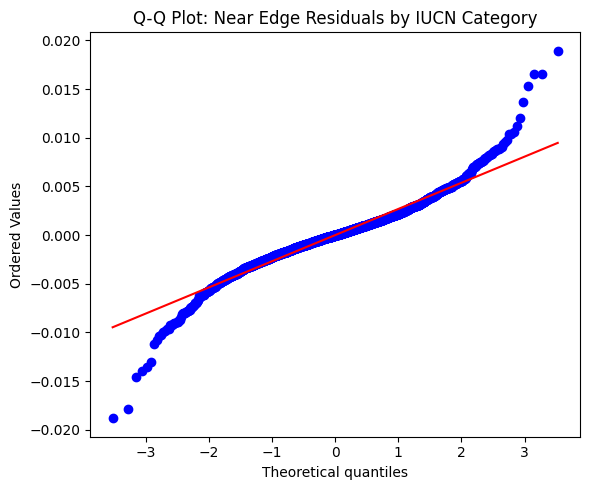

In [8]:
# Check normality of residuals
plot_qq_residuals(anova_iucn_near['data'], 'edge_level_slope', 'IUCN_CAT', 
                  title="Near Edge Residuals by IUCN Category")

### 4.2 Protected Area Size

In [9]:
# PA Size Analysis (log-transformed)

# Near edge trends
model_size_near = run_linear_regression(
    df,
    response_var='edge_level_slope',
    predictor_var='AREA_DISSO',
    log_transform=True,
    title="PA SIZE - Near Edge Trends"
)

# Far edge trends
model_size_far = run_linear_regression(
    df,
    response_var='edge_level_far_slope',
    predictor_var='AREA_DISSO',
    log_transform=True,
    title="PA SIZE - Far Edge Trends"
)

PA SIZE - Near Edge Trends
Linear Regression: edge_level_slope ~ log(AREA_DISSO)
  N = 5009 PAs
                            OLS Regression Results                            
Dep. Variable:       edge_level_slope   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2610
Date:                Sat, 15 Nov 2025   Prob (F-statistic):              0.609
Time:                        01:06:59   Log-Likelihood:                 22310.
No. Observations:                5009   AIC:                        -4.462e+04
Df Residuals:                    5007   BIC:                        -4.460e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

### 4.3 Biome

BIOME - Near Edge Trends
ANOVA: edge_level_slope ~ biome
  N = 5009 PAs
  F-statistic = 0.5956
  p-value = 7.82e-01

             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
       group1              group2       meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------------------
     Boreal-Forests              Desert     -0.0    1.0 -0.0006 0.0006  False
     Boreal-Forests Grassland-Shrubland   0.0001 0.9974 -0.0004 0.0006  False
     Boreal-Forests            Mangrove   0.0009 0.8701  -0.001 0.0028  False
     Boreal-Forests          Rock & Ice   0.0007 0.9769 -0.0013 0.0027  False
     Boreal-Forests   Temperate-Forests   0.0001 0.9996 -0.0004 0.0006  False
     Boreal-Forests    Tropical-Forests   0.0001 0.9981 -0.0004 0.0006  False
     Boreal-Forests              Tundra      0.0    1.0 -0.0009 0.0009  False
     Boreal-Forests             Unknown  -0.0007 0.9984 -0.0038 0.0024  False
             Desert Grass

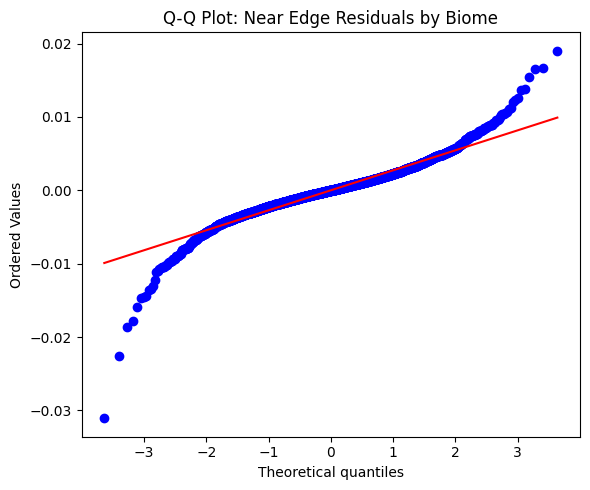

In [10]:
# Biome Analysis

# Near edge trends
anova_biome_near = run_anova_analysis(
    df,
    response_var='edge_level_slope',
    group_var='biome',
    title="BIOME - Near Edge Trends"
)

# Far edge trends
anova_biome_far = run_anova_analysis(
    df,
    response_var='edge_level_far_slope',
    group_var='biome',
    title="BIOME - Far Edge Trends"
)

# Check normality
plot_qq_residuals(anova_biome_near['data'], 'edge_level_slope', 'biome',
                  title="Near Edge Residuals by Biome")

### 4.4 Establishment Year

In [11]:
# Establishment Year Analysis

# Near edge trends
model_year_near = run_linear_regression(
    df,
    response_var='edge_level_slope',
    predictor_var='STATUS_YR',
    log_transform=False,
    title="ESTABLISHMENT YEAR - Near Edge Trends"
)

# Far edge trends
model_year_far = run_linear_regression(
    df,
    response_var='edge_level_far_slope',
    predictor_var='STATUS_YR',
    log_transform=False,
    title="ESTABLISHMENT YEAR - Far Edge Trends"
)

ESTABLISHMENT YEAR - Near Edge Trends
Linear Regression: edge_level_slope ~ STATUS_YR
  N = 5009 PAs
                            OLS Regression Results                            
Dep. Variable:       edge_level_slope   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9129
Date:                Sat, 15 Nov 2025   Prob (F-statistic):              0.339
Time:                        01:07:00   Log-Likelihood:                 22311.
No. Observations:                5009   AIC:                        -4.462e+04
Df Residuals:                    5007   BIC:                        -4.460e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

## 5. Mixed Effects Model

Test the relationship between edge level, year, and human modification, accounting for repeated measures within protected areas.

In [12]:
# Mixed effects model: edge_level ~ year + hm_mean_all + (1|WDPA_PID)
# This accounts for repeated measurements within each PA

# Prepare data - keep all PA-year combinations for longitudinal analysis
mixed_data = df[['WDPA_PID', 'year', 'edge_level', 'edge_level_far', 'hm_mean_all']].dropna().copy()
mixed_data['WDPA_PID'] = mixed_data['WDPA_PID'].astype(str)

print("="*60)
print("MIXED EFFECTS MODEL")
print("="*60)
print(f"N observations: {len(mixed_data)} (PA-year combinations)")
print(f"N protected areas: {mixed_data['WDPA_PID'].nunique()}")
print(f"N years: {mixed_data['year'].nunique()}")
print(f"Avg observations per PA: {len(mixed_data) / mixed_data['WDPA_PID'].nunique():.1f}")

# Model 1: Near edge
print("\n--- Model 1: edge_level ~ year + hm_mean_all + (1|WDPA_PID) ---")
mixed_model_near = smf.mixedlm(
    "edge_level ~ year + hm_mean_all", 
    data=mixed_data, 
    groups=mixed_data["WDPA_PID"]
).fit()
print(mixed_model_near.summary())

# Model 2: Far edge
print("\n--- Model 2: edge_level_far ~ year + hm_mean_all + (1|WDPA_PID) ---")
mixed_model_far = smf.mixedlm(
    "edge_level_far ~ year + hm_mean_all", 
    data=mixed_data, 
    groups=mixed_data["WDPA_PID"]
).fit()
print(mixed_model_far.summary())

MIXED EFFECTS MODEL
N observations: 105081 (PA-year combinations)
N protected areas: 5004
N years: 21
Avg observations per PA: 21.0

--- Model 1: edge_level ~ year + hm_mean_all + (1|WDPA_PID) ---


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: edge_level 
No. Observations: 105081  Method:             REML       
No. Groups:       5004    Scale:              0.0048     
Min. group size:  20      Log-Likelihood:     123555.3095
Max. group size:  21      Converged:          Yes        
Mean group size:  21.0                                   
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       1.123    0.071 15.782 0.000  0.983  1.262
year           -0.000    0.000 -1.595 0.111 -0.000  0.000
hm_mean_all     0.009    0.006  1.558 0.119 -0.002  0.021
Group Var       0.005    0.001                           


--- Model 2: edge_level_far ~ year + hm_mean_all + (1|WDPA_PID) ---
           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: edge_level_far
No. Observations: 

## 6. Summary of Results

Key findings from the statistical analyses.

In [13]:
# Generate summary statistics table
summary_results = {
    'Analysis': [],
    'Test': [],
    'Statistic': [],
    'P-value': [],
    'Interpretation': []
}

# Overall trends
summary_results['Analysis'].append('Overall Trend')
summary_results['Test'].append('One-sample t-test')
summary_results['Statistic'].append(f"t={t_stat1:.2f}")
summary_results['P-value'].append(f"{p_val1:.2e}")
summary_results['Interpretation'].append('Significant' if p_val1 < 0.05 else 'Not significant')

# IUCN
summary_results['Analysis'].append('IUCN Category')
summary_results['Test'].append('ANOVA')
summary_results['Statistic'].append(f"F={anova_iucn_near['f_stat']:.2f}")
summary_results['P-value'].append(f"{anova_iucn_near['p_value']:.2e}")
summary_results['Interpretation'].append('Trends vary by IUCN category' if anova_iucn_near['p_value'] < 0.05 else 'No difference')

# Size
summary_results['Analysis'].append('PA Size')
summary_results['Test'].append('Linear Regression')
summary_results['Statistic'].append(f"β={model_size_near.params[1]:.4f}")
summary_results['P-value'].append(f"{model_size_near.pvalues[1]:.2e}")
summary_results['Interpretation'].append('Trends vary with size' if model_size_near.pvalues[1] < 0.05 else 'No relationship')

# Biome
summary_results['Analysis'].append('Biome')
summary_results['Test'].append('ANOVA')
summary_results['Statistic'].append(f"F={anova_biome_near['f_stat']:.2f}")
summary_results['P-value'].append(f"{anova_biome_near['p_value']:.2e}")
summary_results['Interpretation'].append('Trends vary by biome' if anova_biome_near['p_value'] < 0.05 else 'No difference')

# Establishment Year
summary_results['Analysis'].append('Establishment Year')
summary_results['Test'].append('Linear Regression')
summary_results['Statistic'].append(f"β={model_year_near.params[1]:.4f}")
summary_results['P-value'].append(f"{model_year_near.pvalues[1]:.2e}")
summary_results['Interpretation'].append('Trends vary with year' if model_year_near.pvalues[1] < 0.05 else 'No relationship')

# Mixed model
summary_results['Analysis'].append('Year + Human Modification')
summary_results['Test'].append('Mixed Effects Model')
summary_results['Statistic'].append(f"β_year={mixed_model_near.params['year']:.4f}")
summary_results['P-value'].append(f"{mixed_model_near.pvalues['year']:.2e}")
summary_results['Interpretation'].append('Significant temporal effect' if mixed_model_near.pvalues['year'] < 0.05 else 'No temporal effect')

summary_df = pd.DataFrame(summary_results)

print("\n" + "="*80)
print("SUMMARY TABLE - NEAR EDGE LEVEL SLOPE ANALYSES")
print("="*80)
print(summary_df.to_string(index=False))
print("\n" + "="*80)


SUMMARY TABLE - NEAR EDGE LEVEL SLOPE ANALYSES
                 Analysis                Test      Statistic  P-value     Interpretation
            Overall Trend   One-sample t-test        t=-1.38 1.68e-01    Not significant
            IUCN Category               ANOVA         F=2.04 5.66e-02      No difference
                  PA Size   Linear Regression       β=0.0000 6.09e-01    No relationship
                    Biome               ANOVA         F=0.60 7.82e-01      No difference
       Establishment Year   Linear Regression      β=-0.0000 3.39e-01    No relationship
Year + Human Modification Mixed Effects Model β_year=-0.0001 1.11e-01 No temporal effect



/tmp/ipykernel_11738/135462553.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summary_results['Statistic'].append(f"β={model_size_near.params[1]:.4f}")
/tmp/ipykernel_11738/135462553.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summary_results['P-value'].append(f"{model_size_near.pvalues[1]:.2e}")
/tmp/ipykernel_11738/135462553.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summary_results['Interpretation'].appen

In [14]:
# Generate summary statistics table for FAR edge analysis
summary_results_far = {
    'Analysis': [],
    'Test': [],
    'Statistic': [],
    'P-value': [],
    'Interpretation': []
}

# Overall trends
summary_results_far['Analysis'].append('Overall Trend')
summary_results_far['Test'].append('One-sample t-test')
summary_results_far['Statistic'].append(f"t={t_stat2:.2f}")
summary_results_far['P-value'].append(f"{p_val2:.2e}")
summary_results_far['Interpretation'].append('Significant' if p_val2 < 0.05 else 'Not significant')

# IUCN
summary_results_far['Analysis'].append('IUCN Category')
summary_results_far['Test'].append('ANOVA')
summary_results_far['Statistic'].append(f"F={anova_iucn_far['f_stat']:.2f}")
summary_results_far['P-value'].append(f"{anova_iucn_far['p_value']:.2e}")
summary_results_far['Interpretation'].append('Trends vary by IUCN category' if anova_iucn_far['p_value'] < 0.05 else 'No difference')

# Size
summary_results_far['Analysis'].append('PA Size')
summary_results_far['Test'].append('Linear Regression')
summary_results_far['Statistic'].append(f"β={model_size_far.params[1]:.4f}")
summary_results_far['P-value'].append(f"{model_size_far.pvalues[1]:.2e}")
summary_results_far['Interpretation'].append('Trends vary with size' if model_size_far.pvalues[1] < 0.05 else 'No relationship')

# Biome
summary_results_far['Analysis'].append('Biome')
summary_results_far['Test'].append('ANOVA')
summary_results_far['Statistic'].append(f"F={anova_biome_far['f_stat']:.2f}")
summary_results_far['P-value'].append(f"{anova_biome_far['p_value']:.2e}")
summary_results_far['Interpretation'].append('Trends vary by biome' if anova_biome_far['p_value'] < 0.05 else 'No difference')

# Establishment Year
summary_results_far['Analysis'].append('Establishment Year')
summary_results_far['Test'].append('Linear Regression')
summary_results_far['Statistic'].append(f"β={model_year_far.params[1]:.4f}")
summary_results_far['P-value'].append(f"{model_year_far.pvalues[1]:.2e}")
summary_results_far['Interpretation'].append('Trends vary with year' if model_year_far.pvalues[1] < 0.05 else 'No relationship')

# Mixed model
summary_results_far['Analysis'].append('Year + Human Modification')
summary_results_far['Test'].append('Mixed Effects Model')
summary_results_far['Statistic'].append(f"β_year={mixed_model_far.params['year']:.4f}")
summary_results_far['P-value'].append(f"{mixed_model_far.pvalues['year']:.2e}")
summary_results_far['Interpretation'].append('Significant temporal effect' if mixed_model_far.pvalues['year'] < 0.05 else 'No temporal effect')

summary_df_far = pd.DataFrame(summary_results_far)

print("\n" + "="*80)
print("SUMMARY TABLE - FAR EDGE LEVEL SLOPE ANALYSES")
print("="*80)
print(summary_df_far.to_string(index=False))
print("\n" + "="*80)


SUMMARY TABLE - FAR EDGE LEVEL SLOPE ANALYSES
                 Analysis                Test      Statistic  P-value              Interpretation
            Overall Trend   One-sample t-test        t=-2.10 3.55e-02                 Significant
            IUCN Category               ANOVA         F=2.05 5.53e-02               No difference
                  PA Size   Linear Regression       β=0.0001 1.40e-01             No relationship
                    Biome               ANOVA         F=0.76 6.42e-01               No difference
       Establishment Year   Linear Regression      β=-0.0000 2.90e-01             No relationship
Year + Human Modification Mixed Effects Model β_year=-0.0001 2.29e-02 Significant temporal effect



/tmp/ipykernel_11738/2859839507.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summary_results_far['Statistic'].append(f"β={model_size_far.params[1]:.4f}")
/tmp/ipykernel_11738/2859839507.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summary_results_far['P-value'].append(f"{model_size_far.pvalues[1]:.2e}")
/tmp/ipykernel_11738/2859839507.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summary_results_far['Interpret

## 7. Export Results

In [15]:
# Export processed data with trends
output_file = '/workspace/results/pa_edge_trends_analysis.csv'
df_export = df[['WDPA_PID', 'year', 'edge_level', 'edge_level_far', 
                'edge_level_slope', 'edge_level_pvalue', 'edge_trend',
                'edge_level_far_slope', 'edge_level_far_pvalue', 'edge_trend_far',
                'IUCN_CAT', 'AREA_DISSO', 'STATUS_YR', 'biome', 
                'ISO3', 'Country_Name', 'Continent_Name',
                'hm_mean_all', 'hm_med_all']].copy()

df_export.to_csv(output_file, index=False)
print(f"Results exported to: {output_file}")
print(f"Rows: {len(df_export)}, Columns: {len(df_export.columns)}")

# Export summary tables
summary_df.to_csv('/workspace/results/statistical_summary_near.csv', index=False)
print(f"Near edge summary table exported to: /workspace/results/statistical_summary_near.csv")

summary_df_far.to_csv('/workspace/results/statistical_summary_far.csv', index=False)
print(f"Far edge summary table exported to: /workspace/results/statistical_summary_far.csv")

Results exported to: /workspace/results/pa_edge_trends_analysis.csv
Rows: 105255, Columns: 19
Near edge summary table exported to: /workspace/results/statistical_summary_near.csv
Far edge summary table exported to: /workspace/results/statistical_summary_far.csv
